# Importing necessary libraries and the dataset

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer, 
    TrainingArguments
)
import torch
import re
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from nltk.corpus import wordnet  # For accessing synonyms
import nlpaug.augmenter.word as naw  # Library for text augmentation
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

ImportError: C extension: pandas.compat._constants not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [2]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

print("Transformers library is working correctly!")


c:\Users\artha\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\artha\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-un

Transformers library is working correctly!


In [3]:
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
print(f"Number of rows in the dataset: {len(df)}")
print(df.head())
# dataset = Dataset.from_pandas(df)
# dataset

NameError: name 'pd' is not defined

# Data Preprocessing

In [ ]:
# Lowercase
df['text'] = df['text'].apply(lambda x: x.lower())
# Removing punctuation
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Removing special characters
df['text'] = df['text'].apply(lambda x: re.sub(r'\d+', '', x))
# Handle missing values
df.dropna(subset=['text', 'label'], inplace=True)


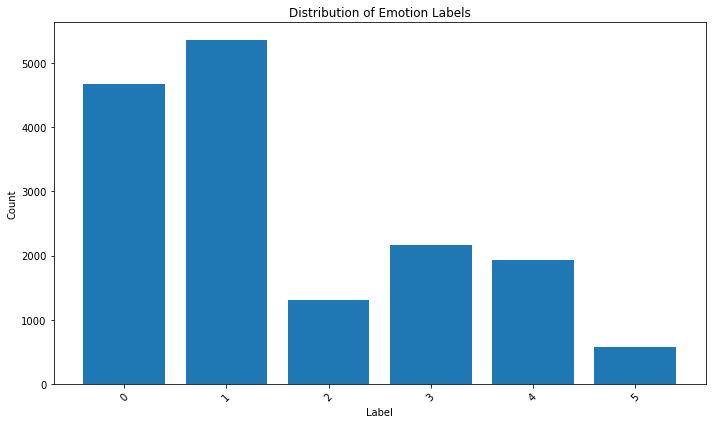

In [ ]:
# Create bar chart of label distribution
label_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values)
plt.title('Distribution of Emotion Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def augment_text(text):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text)[0]
    return augmented_text

# Create balanced dataset with augmentation
balanced_dfs = []
max_size = df['label'].value_counts().max()

for label in df['label'].unique():
    class_df = df[df['label'] == label]
    if len(class_df) < max_size:
        # Calculate how many augmented samples we need
        n_aug = max_size - len(class_df)
        # Original samples
        balanced_dfs.append(class_df)
        
        # Augmented samples
        aug_df = class_df.sample(n=n_aug, replace=True)
        aug_df['text'] = aug_df['text'].apply(augment_text)
        balanced_dfs.append(aug_df)
    else:
        balanced_dfs.append(class_df)

balanced_df = pd.concat(balanced_dfs, ignore_index=True)
dataset = Dataset.from_pandas(balanced_df)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sayantan Datta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger_eng[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/averaged_perceptron_tagger_eng/[0m

  Searched in:
    - 'C:\\Users\\Sayantan Datta/nltk_data'
    - 'c:\\Users\\Sayantan Datta\\anaconda3\\envs\\pytorch\\nltk_data'
    - 'c:\\Users\\Sayantan Datta\\anaconda3\\envs\\pytorch\\share\\nltk_data'
    - 'c:\\Users\\Sayantan Datta\\anaconda3\\envs\\pytorch\\lib\\nltk_data'
    - 'C:\\Users\\Sayantan Datta\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 32172
})

In [ ]:
# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=31)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
)

# Fine-tune the model
trainer.train()

c:\Users\Sayantan Datta\anaconda3\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Sayantan Datta\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of DistilBertForSequenceClassification were not initialized from the model ch

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
print(torch.cuda.is_available())

False
